Seongmin Hwang 20102127

Marion SCHMITT 25170158

Name3 ID

**Data Science Practice : Project**

# Analyzing the Relationship between News Bias and Audience Influence

**Objective: Predict the influence of a media outlet based on its bias**

In [84]:
import pandas as pd 
import numpy as np
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from wordcloud import WordCloud

### Bias Lexique

In [63]:
# AI HUB (json) file
files_to_load = [f"talksets-train-{i}.json" for i in range(1, 7)]

aihub_data = []
for file_name in files_to_load:
    with open(file_name, 'r', encoding='utf-8') as f :
        aihub_data.extend(json.load(f))

len(aihub_data)

118103

In [65]:
# !!!!! not too sure about this part

# Extract immoral sentences
immoral_sentences = [
    s["text"]
    for entry in aihub_data
    for s in entry.get("sentences", [])
    if s.get("is_immoral") is True and "text" in s
]

print(len(immoral_sentences))
immoral_sentences[:5]

225077


['부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네',
 '맞아. 사람들이 진짜 개념이없다',
 '저렇게는 살지 말아야지',
 '그러게 게으르고 멍청한 사람들은 맞아야해',
 '인방 보는 남자는 거르는게 맞다']

### Immoral lexic : N-gram

In [85]:
# N-gram : unethical lexicon
vectorizer = CountVectorizer(
    ngram_range=(2, 3),    # bi-gram + tri-gram
    min_df=5,
)

X_immoral = vectorizer.fit_transform(immoral_sentences)
unethical_terms = vectorizer.get_feature_names_out()

len(unethical_terms)

12966

### Bias Score :

In [86]:
df_bigkinds = pd.read_excel('NewsResult_20241127-20251127.xlsx', sheet_name = 'sheet')
print(df_bigkinds.columns.tolist())

# Columns definition
MEDIA_COL = "언론사"
TEXT_COL = "키워드"

df_bigkinds.dropna(subset=[MEDIA_COL, KEYWORD_COL], inplace=True)

# Extract first 20 chara of each article
df_bigkinds["excerpt"] = df_bigkinds[TEXT_COL].astype(str).str[:200]

['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3', '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드', '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부']


### Count immoral N-gram

In [87]:
# Count N-grams
vectorizer_news = CountVectorizer(
    vocabulary=unethical_terms,   # fixed vocab = immoral lexicon
    ngram_range=(2, 3)
)

X_news = vectorizer_news.transform(df_bigkinds["excerpt"])
unethical_counts = np.asarray(X_news.sum(axis=1)).ravel()



# Compute bias score
df_bigkinds["unethical_count"] = unethical_counts
df_bigkinds["word_count"] = df_bigkinds["excerpt"].str.split().str.len()

df_bigkinds["Bias_Score"] = df_bigkinds["unethical_count"] / (df_bigkinds["word_count"] + 1)

### Influence Score :

In [70]:
df_traffic = pd.read_excel('datalab_all.xlsx', sheet_name='Sheet1')
print(df_traffic.columns.tolist())

# Columns definition
ID_COL = '날짜'
MEDIA_COLUMNS = [col for col in df_traffic.columns if col != ID_COL]


# Processing, conversion
results_dict = {}

for media in MEDIA_COLUMNS:
    # Conversion and remove NaNs (created by conversion)
    values = pd.to_numeric(df_traffic[media], errors="coerce").dropna()
    
    # Mean
    results_dict[media] = values.mean()
    

# Feature Engineering
influence_df = pd.DataFrame(results_dict.items(), columns=["Media_Name", "AVG_TREND_INDEX"])
influence_df["Influence_Score"] = np.log(influence_df["AVG_TREND_INDEX"] + 1e-6)

['날짜', '경향신문', '국민일보', '내일신문', '동아일보', '문화일보', '서울신문', '세계일보', '아시아투데이', '朝鮮日報', '중앙일보', '한겨레', '한국일보', 'KBS', 'MBC', 'OBS', 'SBS', 'YTN', '시사IN']


### Fusion Bias + Influence

In [71]:
# Datafram fusion
final_df = df_bigkinds.merge(
    influence_df,
    left_on=MEDIA_COL,
    right_on="Media_Name",
    how="left"
)

final_df = final_df[["언론사", "Bias_Score", "Influence_Score"]]
final_df.head()

,언론사,Bias_Score,Influence_Score
0,서울신문,0.5,-0.042057
1,아시아투데이,0.0,-0.319498
2,문화일보,0.0,0.881770
3,문화일보,0.0,0.881770
4,아시아투데이,0.0,-0.319498


### Clustering (K-Means)

In [75]:
X = final_df[["Bias_Score", "Influence_Score"]].dropna()

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=3, random_state=42))
])

clusters = pipeline.fit_predict(X)

final_df.loc[X.index, "cluster"] = clusters
final_df.head()


,언론사,Bias_Score,Influence_Score,cluster
0,서울신문,0.5,-0.042057,1.0
1,아시아투데이,0.0,-0.319498,0.0
2,문화일보,0.0,0.881770,2.0
3,문화일보,0.0,0.881770,2.0
4,아시아투데이,0.0,-0.319498,0.0


### Visualization

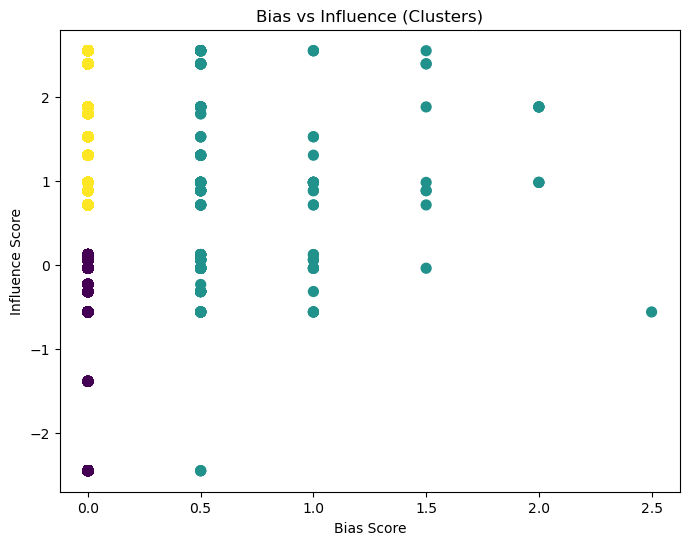

In [82]:
# !!!!!!! to be reviewed, done with GPT


plt.figure(figsize=(8,6))
plt.scatter(
    final_df["Bias_Score"],
    final_df["Influence_Score"],
    c=final_df["cluster"],
    s=50
)
plt.xlabel("Bias Score")
plt.ylabel("Influence Score")
plt.title("Bias vs Influence (Clusters)")
plt.show()


### WordCloud of immoral N-grams

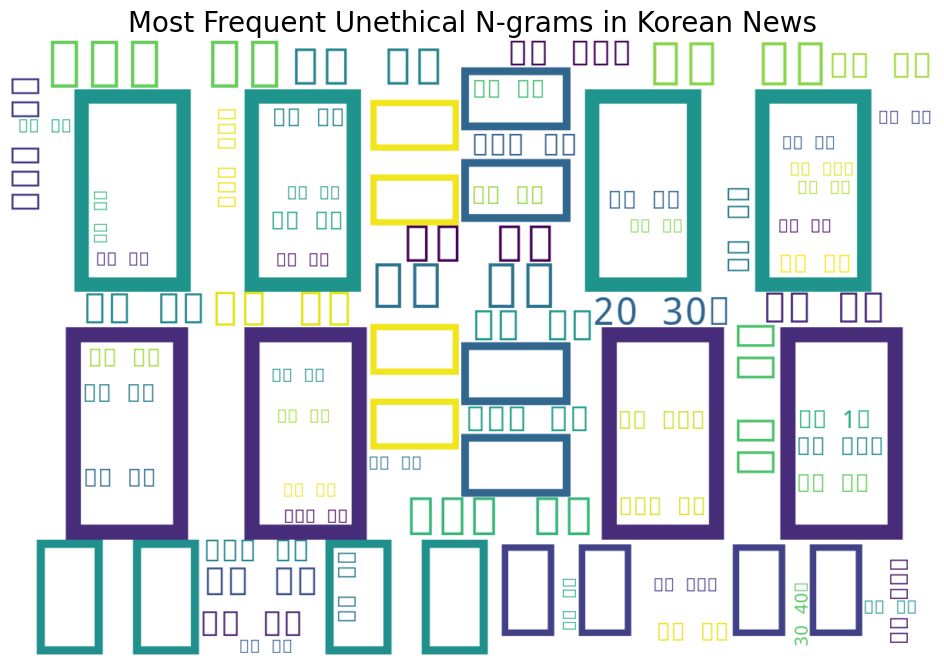

In [89]:
# # !!!!!!! to be reviewed, done with GPT

# Total frequency of n-grams
X_total = X_news.sum(axis=0)
term_frequencies = {
    term: int(X_total[0, i])
    for i, term in enumerate(unethical_terms)
}

wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    colormap="viridis"
).generate_from_frequencies(term_frequencies)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Unethical N-grams in Korean News", fontsize=20)
plt.show()
